<a href="https://colab.research.google.com/github/Chahatchopra/Human-Activity-Recognition/blob/main/HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pafy youtube-dl moviepy

In [ ]:
# Libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Downlaoding the Dataset

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar #Extracting

--2024-04-09 18:39:18--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar.1’

UCF50.rar.1           7%[>                   ] 239.35M  51.9MB/s    eta 60s    ^C

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from UCF50.rar


Would you like to replace the existing file UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi
318098 bytes, modified on 2010-10-01 15:49
with a new one
318098 bytes, modified on 2010-10-01 15:49

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


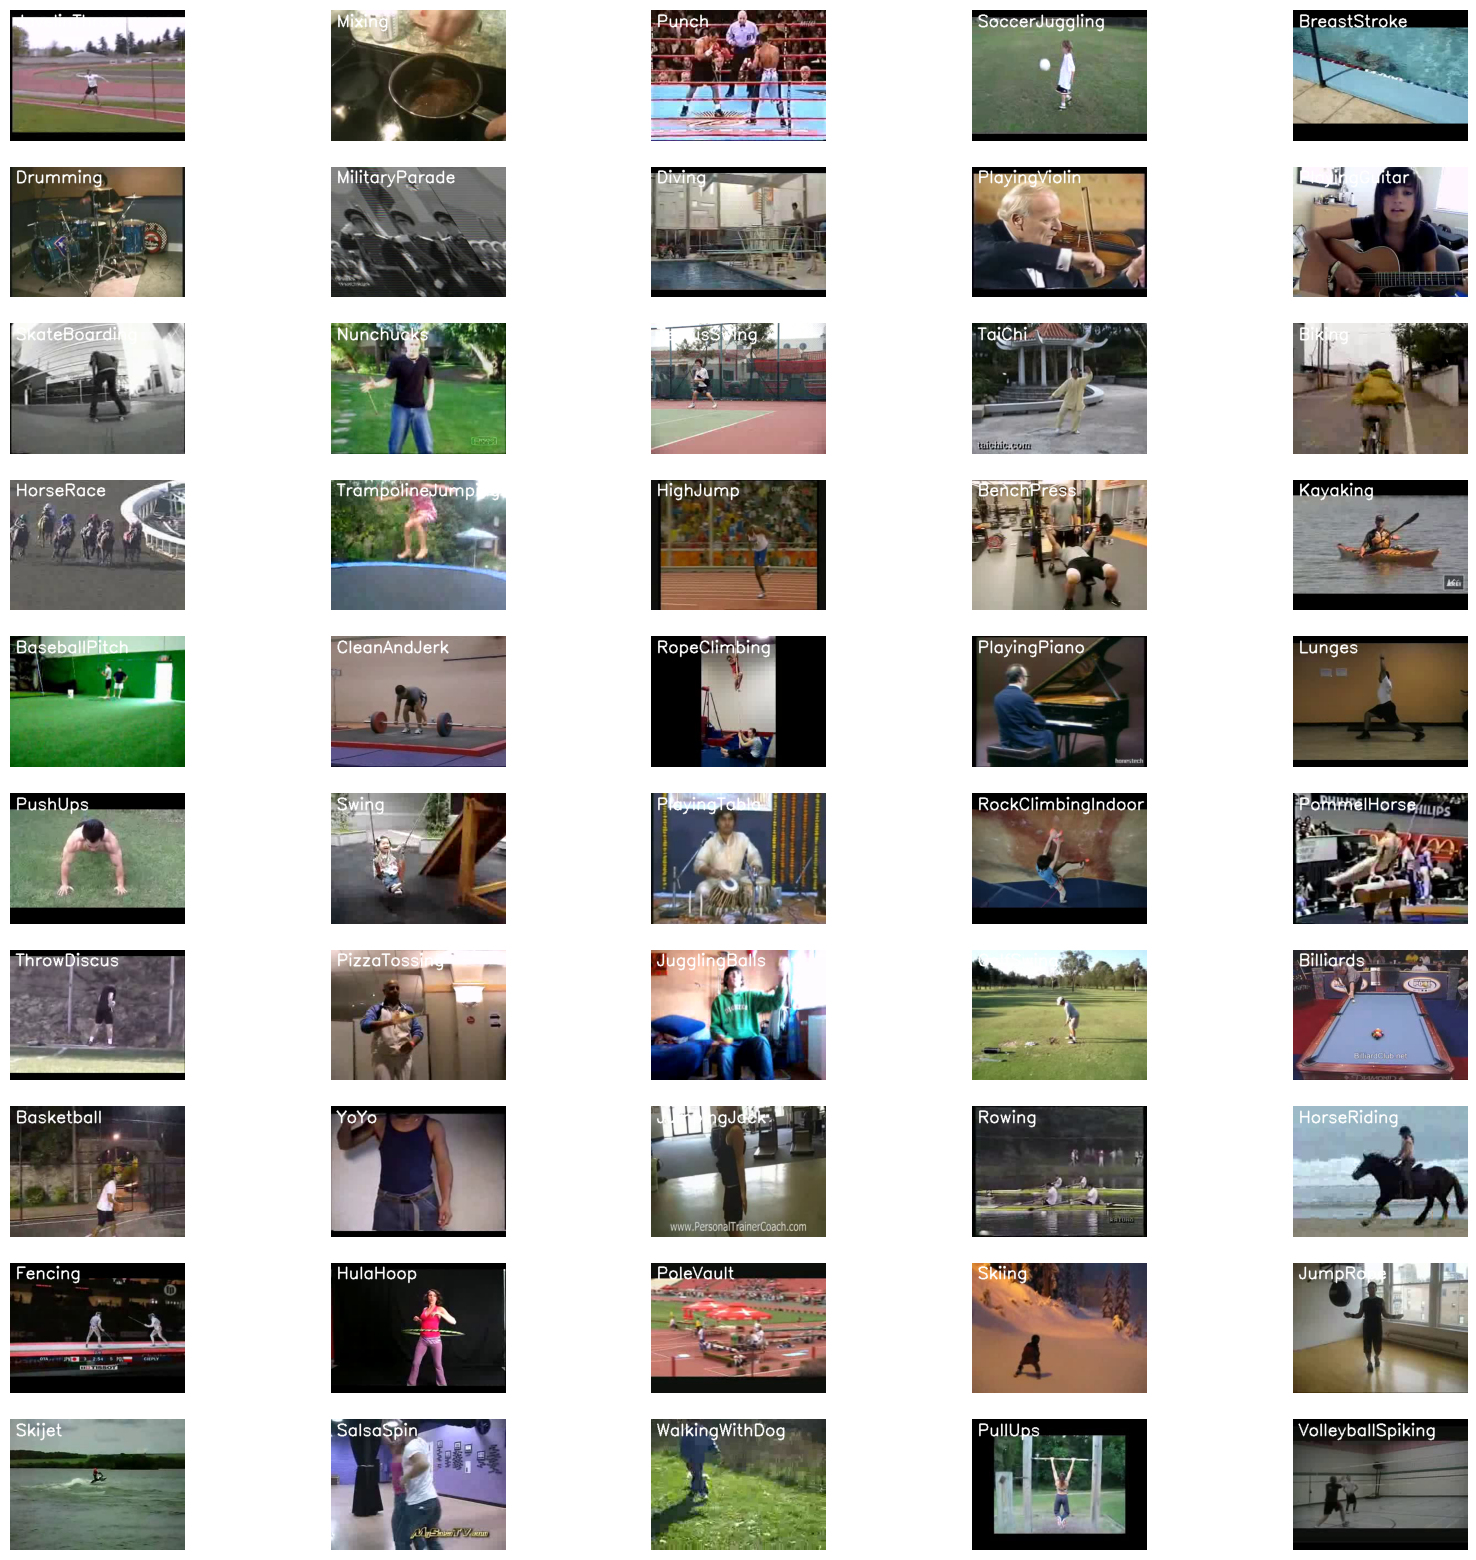

In [ ]:
plt.figure(figsize = (20, 20))
# names of all classes in UCF50.
all_classes_names = os.listdir('UCF50')

# list of random values
random_range = random.sample(range(len(all_classes_names)), 50)
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index] #Retrieving a Class Name
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}') #Retrieving list of all the videos
    selected_video_file_name = random.choice(video_files_names_list) #Random selection of video
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read() # Reading the first frame
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(10, 5, counter);plt.imshow(rgb_frame);plt.axis('off') #show or display

In [ ]:
all_classes_names = os.listdir('UCF50')
print(all_classes_names)

['PizzaTossing', 'RockClimbingIndoor', 'Lunges', 'HorseRiding', 'MilitaryParade', 'YoYo', 'WalkingWithDog', 'PullUps', 'GolfSwing', 'Basketball', 'Rowing', 'Biking', 'Drumming', 'Swing', 'PommelHorse', 'HorseRace', 'PlayingViolin', 'SoccerJuggling', 'BreastStroke', 'PushUps', 'CleanAndJerk', 'SkateBoarding', 'VolleyballSpiking', 'TennisSwing', 'Skiing', 'TaiChi', 'JumpingJack', 'Skijet', 'PlayingPiano', 'BaseballPitch', 'Mixing', 'HighJump', 'Billiards', 'JugglingBalls', 'PlayingGuitar', 'ThrowDiscus', 'HulaHoop', 'Kayaking', 'Fencing', 'PoleVault', 'TrampolineJumping', 'JavelinThrow', 'BenchPress', 'Diving', 'Punch', 'RopeClimbing', 'SalsaSpin', 'JumpRope', 'PlayingTabla', 'Nunchucks']


In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
# CLASSES_LIST = ["SkateBoarding", "VolleyballSpiking", "Swing", "HorseRace","HulaHoop", "JavelinThrow","JumpingJack","Lunges","MilitaryParade","Nunchucks"]

In [ ]:
def frames_extraction(video_path):
    # to store video frames.
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH): # Iterate through the Video Frames.
    # Set the current frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame so, that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
class_list=['Basketball','VolleyballSpiking','PlayingViolin','PlayingGuitar','PullUps','CleanAndJerk']

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(class_list):
        print(f'Extracting Data of Class: {class_name}')
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths



In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: PlayingViolin
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PullUps
Extracting Data of Class: CleanAndJerk


In [ ]:
one_hot_encoded_labels = to_categorical(labels) # Using Keras's to_categorical method to convert labels into one-hot-encoded vectors

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():

    model = Sequential()
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 18, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last", recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(class_list), activation = "softmax"))
    model.summary()

    return model

LRCN model

In [ ]:
# LRCN model
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(class_list), activation = 'softmax'))


    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 20, 31, 31, 4)     0         
 g3D)                                                            
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 31, 31, 4)     0         
 stributed)                                                      
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

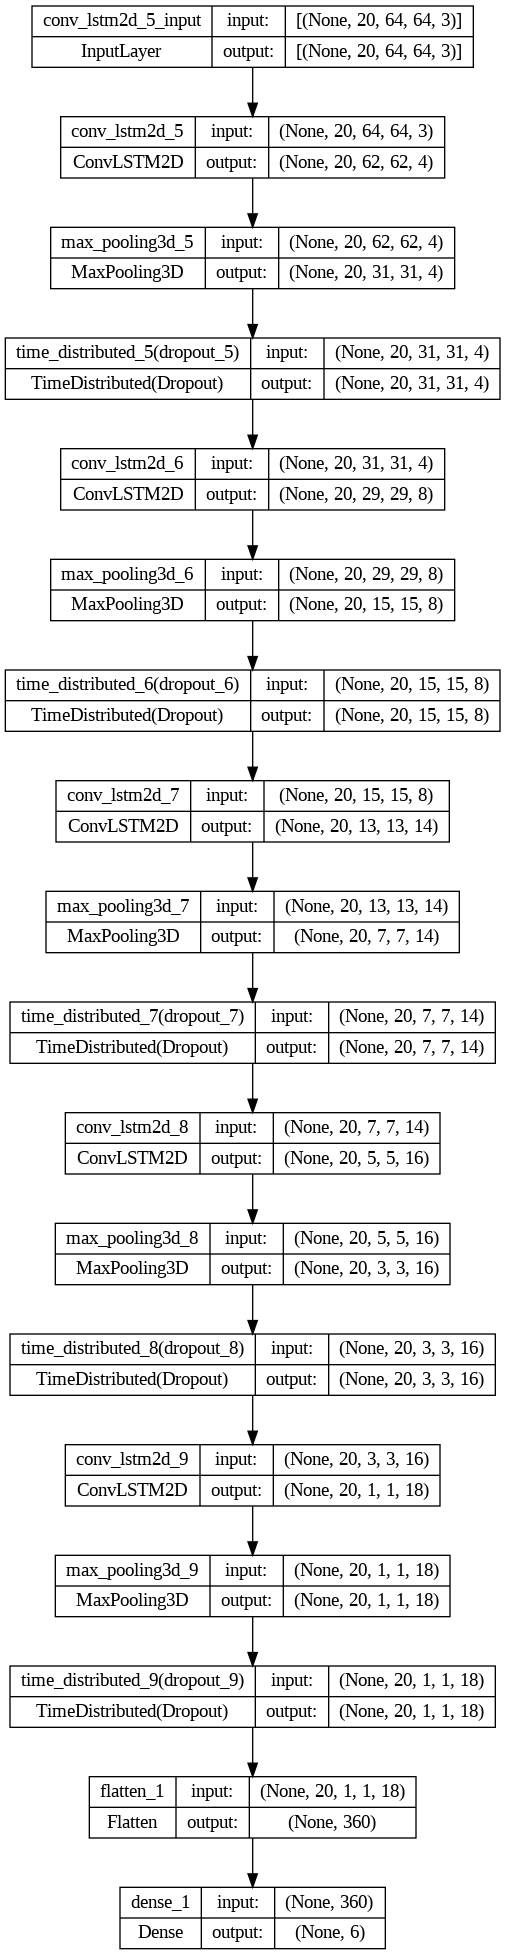

In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# LRCN model
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 4, 4, 32)     

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
112/112 [==============================] - 200s 2s/step - loss: 1.7612 - accuracy: 0.2220 - val_loss: 1.9006 - val_accuracy: 0.2054
Epoch 2/50
112/112 [==============================] - 184s 2s/step - loss: 1.6285 - accuracy: 0.3161 - val_loss: 1.4474 - val_accuracy: 0.4018
Epoch 3/50
112/112 [==============================] - 187s 2s/step - loss: 1.2965 - accuracy: 0.4955 - val_loss: 1.3017 - val_accuracy: 0.4732
Epoch 4/50
112/112 [==============================] - 183s 2s/step - loss: 1.0596 - accuracy: 0.5785 - val_loss: 1.2007 - val_accuracy: 0.4643
Epoch 5/50
112/112 [==============================] - 183s 2s/step - loss: 0.9520 - accuracy: 0.6323 - val_loss: 1.0056 - val_accuracy: 0.6071
Epoch 6/50
112/112 [==============================] - 184s 2s/step - loss: 0.7859 - accuracy: 0.7063 - val_loss: 1.1452 - val_accuracy: 0.5446
Epoch 7/50
112/112 [==============================] - 183s 2s/step - loss: 0.7483 - accuracy: 0.7175 - val_loss: 0.8682 - val_accuracy: 0.6786

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

6/6 [==============================] - 19s 3s/step - loss: 0.9126 - accuracy: 0.7433


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving the model
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

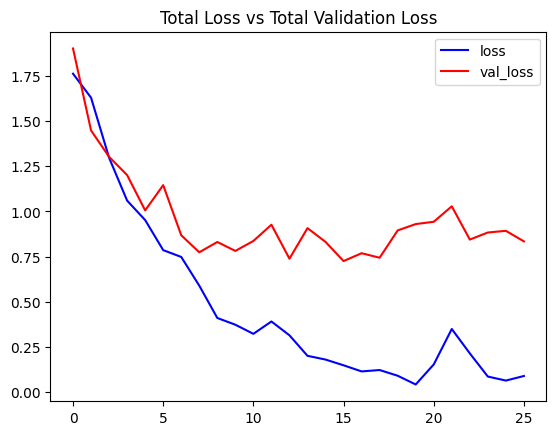

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

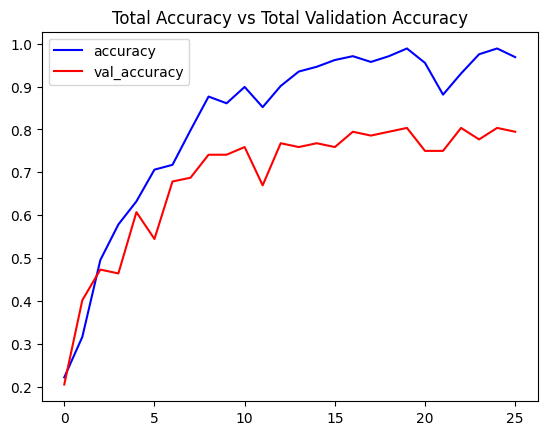

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
# build a confusion matrix

import numpy as np
from sklearn.metrics import confusion_matrix
y_pred = convlstm_model.predict(features_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)


6/6 [==============================] - 20s 3s/step
[[25  6  0  0  1  0]
 [11 14  0  1  2  3]
 [ 0  0 19  3  2  0]
 [ 1  1  0 38  1  0]
 [ 1  1  4  1 26  4]
 [ 2  1  1  0  1 17]]


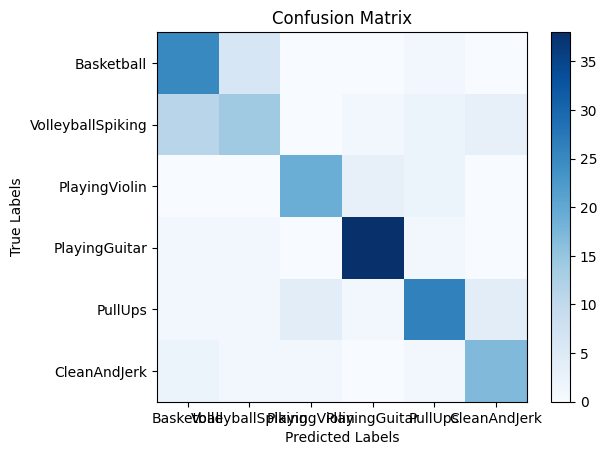

In [ ]:
# display the confusion matrix using matplotlib library

import numpy as np
import matplotlib.pyplot as plt

plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.xticks(np.arange(len(class_list)), class_list)
plt.yticks(np.arange(len(class_list)), class_list)
plt.show()


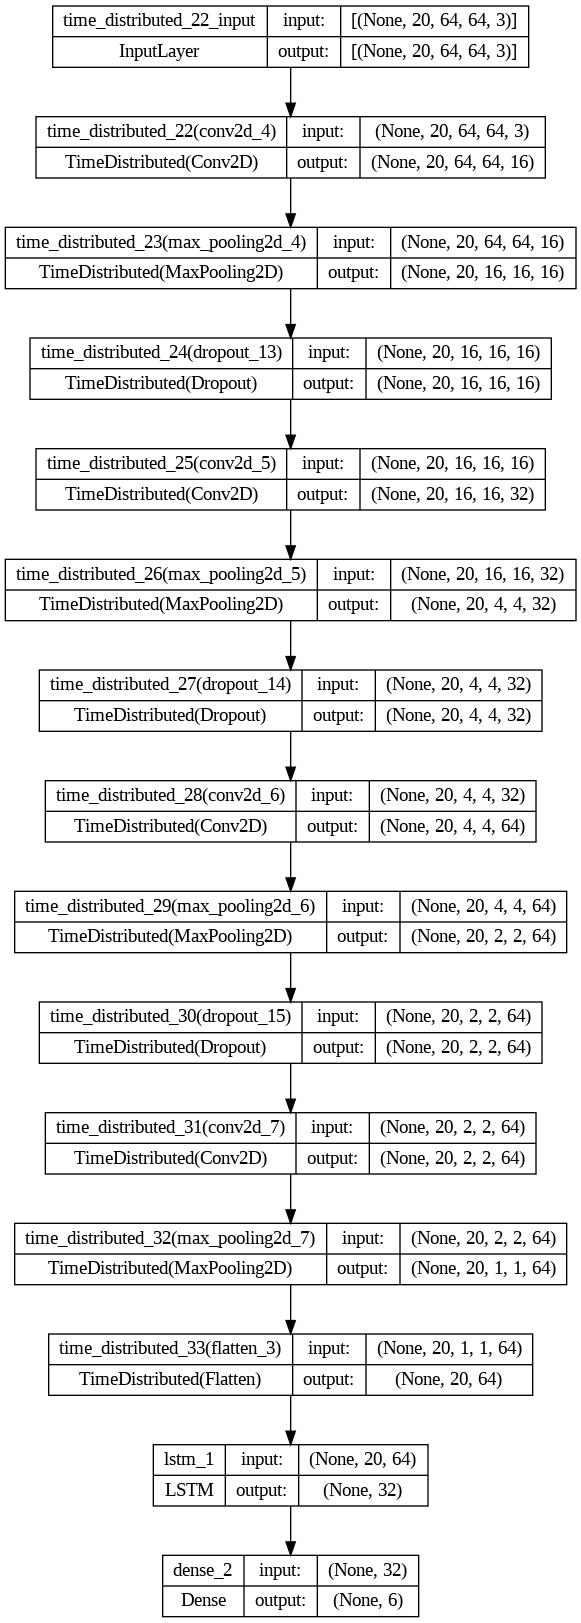

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
112/112 [==============================] - 24s 188ms/step - loss: 1.8021 - accuracy: 0.1996 - val_loss: 1.7941 - val_accuracy: 0.1250
Epoch 2/70
112/112 [==============================] - 18s 158ms/step - loss: 1.7428 - accuracy: 0.2466 - val_loss: 1.7314 - val_accuracy: 0.2143
Epoch 3/70
112/112 [==============================] - 20s 179ms/step - loss: 1.5827 - accuracy: 0.3251 - val_loss: 1.6394 - val_accuracy: 0.2768
Epoch 4/70
112/112 [==============================] - 19s 171ms/step - loss: 1.4170 - accuracy: 0.3901 - val_loss: 1.2408 - val_accuracy: 0.5625
Epoch 5/70
112/112 [==============================] - 19s 166ms/step - loss: 1.3184 - accuracy: 0.4484 - val_loss: 1.1402 - val_accuracy: 0.5982
Epoch 6/70
112/112 [==============================] - 18s 157ms/step - loss: 1.0547 - accuracy: 0.5717 - val_loss: 1.1056 - val_accuracy: 0.5357
Epoch 7/70
112/112 [==============================] - 20s 175ms/step - loss: 0.9185 - accuracy: 0.6525 - val_loss: 1.0029 - val_ac

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 [==============================] - 4s 560ms/step - loss: 0.4085 - accuracy: 0.8503


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

  saving_api.save_model(



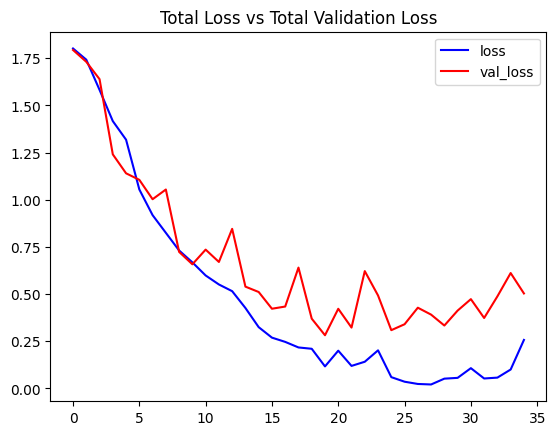

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

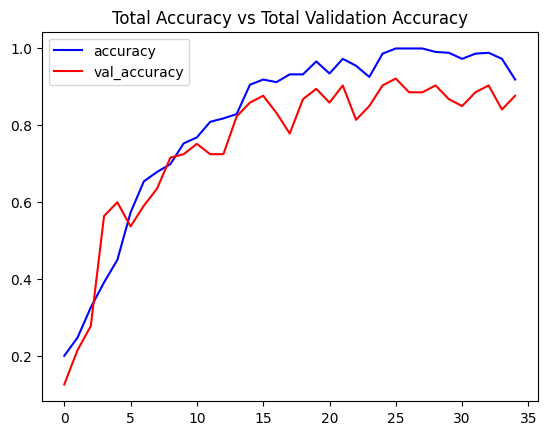

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

6/6 [==============================] - 3s 407ms/step
[[21 10  0  0  1  0]
 [ 3 21  0  0  7  0]
 [ 0  0 23  1  0  0]
 [ 0  0  0 41  0  0]
 [ 0  0  2  0 33  2]
 [ 0  0  0  0  2 20]]


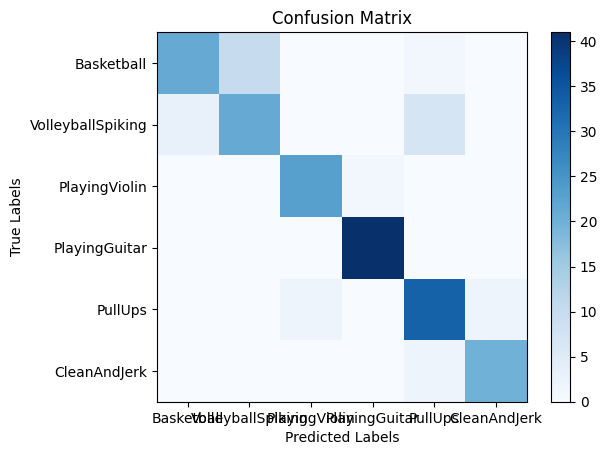

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
# build a confusion matrix
y_pred = LRCN_model.predict(features_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)

# display the confusion matrix using matplotlib library


plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.xticks(np.arange(len(class_list)), class_list)
plt.yticks(np.arange(len(class_list)), class_list)
plt.show()


In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     video = pafy.new(youtube_video_url)
     title = video.title
     video_best = video.getbest()
     output_file_path = f'{output_directory}/{title}.mp4'
     video_best.download(filepath = output_file_path, quiet = True)
     return title

In [ ]:
# def download_youtube_videos(youtube_video_url, output_directory):
#     ydl_opts = {
#         'outtmpl': f'{output_directory}/%(title)s.%(ext)s',
#     }
#     with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#         ydl.download([youtube_video_url])
#         video_title = ydl.extract_info(youtube_video_url, download=False)['title']
#         return video_title

In [ ]:
!pip install --upgrade youtube-dl

In [ ]:
import youtube_dl

In [ ]:
# import os
# import subprocess

# def download_youtube_videos(url, output_directory, verbose=False):
#     command = ['youtube-dl', url, '-o', f'{output_directory}/%(title)s.%(ext)s']
#     if verbose:
#         command.append('--verbose')
#     subprocess.call(command)

# test_videos_directory = 'test_videos'
# os.makedirs(test_videos_directory, exist_ok=True)

# # Download a YouTube Video.
# video_title=download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory, verbose=True)

# # Get the YouTube Video's path we just downloaded.
# # video_title = 'Test Video'  # You need to provide the video title or handle it dynamically
# input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


In [ ]:

def download_youtube_videos(url, output_directory, verbose=False):
    command = ['youtube-dl', url, '-o', f'{output_directory}/%(title)s.%(ext)s']
    if verbose:
        command.append('--verbose')
    subprocess.call(command)

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# Download a YouTube Video.
video_title=download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory, verbose=True)

# Get the YouTube Video's path we just downloaded.
# video_title = 'Test Video'  # You need to provide the video title or handle it dynamically
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'


In [ ]:
input_video_file_path='/content/test_videos/v_PlayingGuitar_g01_c02.avi'

In [ ]:
test_videos_directory = 'test_videos'

In [ ]:
video_title='Playing Guitar'

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

# Download a YouTube Video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

# Get the YouTube Video's path we just downloaded.
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''


    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = class_list[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)


        if len(frames_queue) == SEQUENCE_LENGTH:


            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]


            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = class_list[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display() # okay :)

1/1 [==============================] - 0s 34ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display() # yeh khrab hai :/

1/1 [==============================] - 0s 133ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
